In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torch.nn.functional as F

# Data loading

In [2]:
test_dataset = pd.read_csv("../benchmark/data/test_dataset.csv")
test_targets = pd.read_csv("../benchmark/data/test_targets.csv")
test_masks = pd.read_csv("../benchmark/data/test_masks.csv")['movie_ids']

In [3]:
def convert_mask(train_masks):
    ans = []
    for elem in train_masks:
        ans.append([int(x) for x in elem[1:-1].split(', ')])
    return ans

test_masks = convert_mask(test_masks.tolist())

In [4]:
device = "cuda"  if torch.cuda.is_available() else 'cpu'

In [5]:
X_test = torch.Tensor(test_dataset.values).to(device)
Y_test = torch.Tensor(test_targets.values).to(device)

# Model architecture

In [6]:
class RecSys(nn.Module):
    def __init__(
        self
    ):
        super(RecSys, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1705, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU()
        )
        self.head = nn.Linear(2048, 1682)

    def forward(self, x):
        deep_logits = self.linear_relu_stack(x)
        total_logits = self.head(deep_logits)
        return F.sigmoid(total_logits)

# Useful functions

In [7]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # if not actual:
    #     return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [8]:
def build_mask(size, offset, indexes):
    mask = [True for _ in range(size)]
    for elem in indexes:
        mask[elem+offset-1] = False
    return torch.tensor(mask)

def mask_target(target, masks):
    masked = []
    for i in range(len(target)):
        elem = target[i]
        mask = build_mask(len(elem), 0, masks[i]).to(device)
        masked_elem =  torch.masked_select(elem, mask)
        masked.append(masked_elem)
    return torch.stack(masked)

def mask_one_row(target, mask):
    torch_mask = build_mask(len(target), 0, mask).to(device)
    return torch.masked_select(target, torch_mask)

Y_test_masked  = mask_target(Y_test, test_masks)

# Evaluation

In [9]:
def evaluate_model(model, K=[5, 10, 20, 50], show = True):
    actuals = []
    predictions = []
    for i in range(len(Y_test)):
        probs = model(X_test[i])
        probs = mask_one_row(probs, test_masks[i])
        temp = probs.detach().cpu().numpy()
        act = Y_test_masked[i].detach().cpu().numpy()
        actuals.append(np.argsort(act)[len(act)-int(sum(act)):])
        predictions.append(np.argsort(temp)[::-1])    
    
    ans = []
    for k in K:
        elem = mapk(actuals, predictions, k)
        ans.append(elem)
        if show:
            print(f"K={k}\tMAP@K: {elem}")
    return ans

Firs't of all let's check our **best** model (one with lowest BCELoss):

In [10]:
model = RecSys().to(device)
model = torch.load("../models/best_model").to(device)
best_model_metrics = evaluate_model(model)

K=5	MAP@K: 0.48472663139329797
K=10	MAP@K: 0.4219677500629882
K=20	MAP@K: 0.3639892879647432
K=50	MAP@K: 0.321287546059767


Now let's evaluate all models that we stored:

In [30]:
EPOCHS = 500
SAVE_STEP = 5

metrics = []
steps = []
highest = 0
highest_metric = 0
for i in range(SAVE_STEP, EPOCHS+SAVE_STEP, SAVE_STEP):
    steps.append(i)
    model = torch.load(f"../models/checkpoint_{i}_model").to(device)
    value = evaluate_model(model, show = False)
    metrics.append(value)
    if value[0] > highest_metric:
        highest_metric = value[0]
        highest = i
highest

185

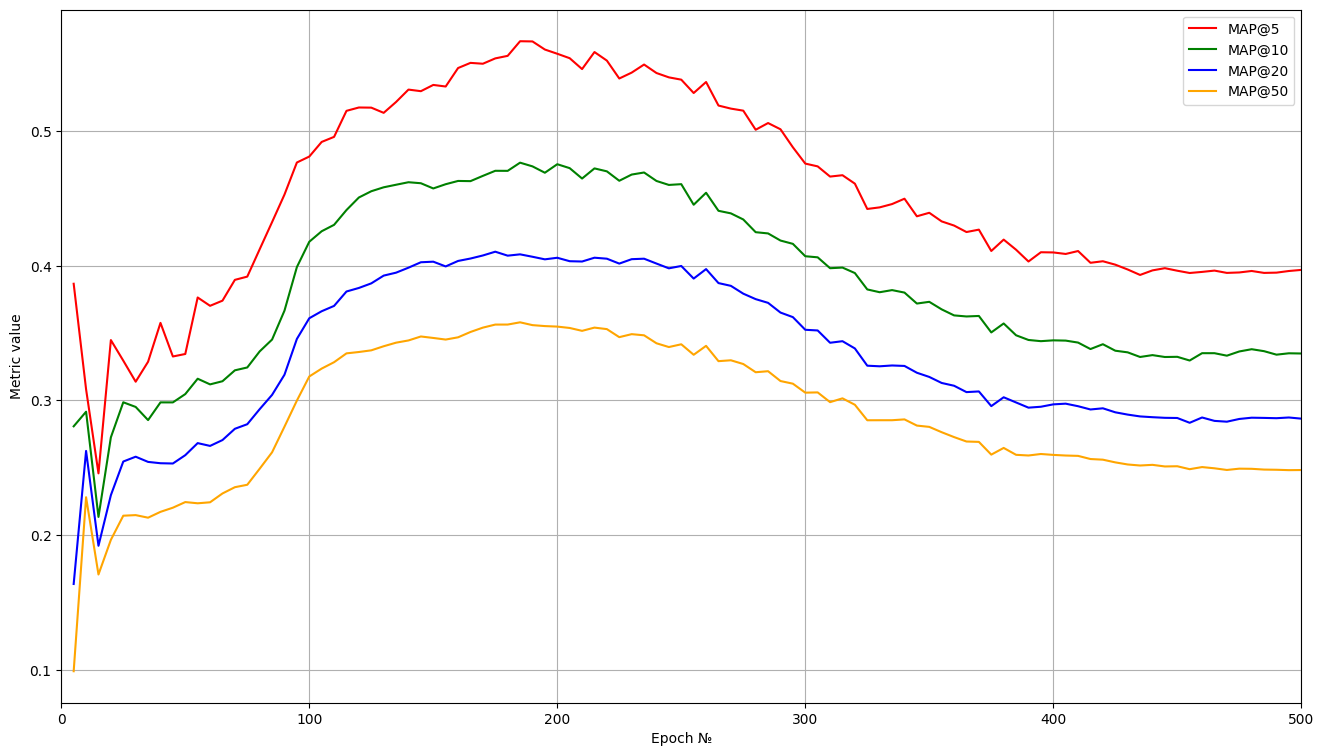

In [34]:
fig, ax = plt.subplots(figsize=(16, 9))
map_5 = [x[0] for x in metrics]
map_10 = [x[1] for x in metrics]
map_20 = [x[2] for x in metrics]
map_50 = [x[3] for x in metrics]
ax.plot(steps, map_5, label = "MAP@5", color='r')
ax.plot(steps, map_10, label = "MAP@10", color='g')
ax.plot(steps, map_20, label = "MAP@20", color='b')
ax.plot(steps, map_50, label = "MAP@50", color='orange')

plt.xlim([0, steps[-1]])
plt.xlabel("Epoch №")
plt.ylabel("Metric value")
plt.legend()
plt.grid()
plt.savefig("../reports/figures/test.png")
plt.show()

Here we can see total domination of models which was trained over 185 and 190 epochs. As for model with lowest BSELost on val set, we can confirm our idea that lower BSELoss doesn't always imply higher MAP@K metric value.

Now let's look closer on results of our RecSys model which was trained over 185 epochs:

In [32]:
model = torch.load("../models/checkpoint_185_model").to(device)
best_model_metrics = evaluate_model(model)

K=5	MAP@K: 0.5668253968253968
K=10	MAP@K: 0.4766223649953808
K=20	MAP@K: 0.4085302330159047
K=50	MAP@K: 0.35804317666532703


And 190 epochs:

In [33]:
model = torch.load("../models/checkpoint_185_model").to(device)
best_model_metrics = evaluate_model(model)

K=5	MAP@K: 0.5668253968253968
K=10	MAP@K: 0.4766223649953808
K=20	MAP@K: 0.4085302330159047
K=50	MAP@K: 0.35804317666532703


As we can see, they are very close to each other.

That means that knowing only users gemographic information(age, gender, occupation, zip code) and favorite movie (10 with highest score) out of 5 films 2-3 would be watched. I think that it's solid performance.